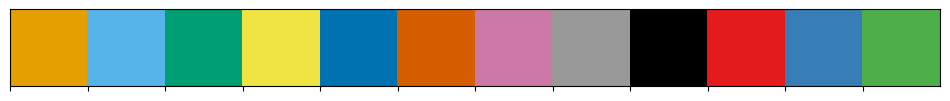

In [1]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import gym
from gym import spaces
import numpy as np
from Stochastic.src.environment.tree import Tree
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
colors = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]
sns.palplot(colors)
colors = sns.color_palette("hls", 12)

In [2]:
class NestedBanditEnv(gym.Env):
    """
    Nested Bandit environment where each arm is a full path from root to leaf in a tree.
    The reward is the sum of sampled node values along the path.
    """

    def __init__(self, seed=None):
        super(NestedBanditEnv, self).__init__()
        self.tree = self.generate_tree()
        means = [self.tree.get_mu_leaf(leaf) for leaf in self.tree.get_all_leaves()]
        self.DELTA = np.array([max(means) - mean for mean in means])
        self.rng = np.random.default_rng(seed)

        self.tree.step()  # initial sampling
        self.leaves = self.tree.get_all_leaves()
        self.K = len(self.leaves)
        self.best_arm = np.argmax([value[2] for value in self.tree.get_mu_leaves()])

        self.action_space = spaces.Discrete(self.K)
        self.observation_space = spaces.Discrete(1)  # stateless

        self.reset()

    def generate_tree(self):
        tree = Tree() 
        root = tree.insert(parent_node=None, name="Targeting", mean=0, var=0)

        # First Layer
        families, _ = tree.insert(parent_node=root, name="families", mean=0.35, var=0.1)
        professionals, _ = tree.insert(parent_node=root, name="professionals", mean=0.45, var=0.1)

        # Second Layer
        adults, _ = tree.insert(parent_node=families, name="adults", mean=0.05, var=0.1)
        youngs, _ = tree.insert(parent_node=families, name="youngs", mean=0.08, var=0.1)

        start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=0.07, var=0.1)
        companies, _ = tree.insert(parent_node=professionals, name="companies", mean=0.15, var=0.1)

        # Third Layer
        radio, _ = tree.insert(parent_node=adults, name="radio", mean=0.03, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="tv", mean=0.02, var=0.1)
        magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=0.01, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=0.03, var=0.1)

        youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=0.01, var=0.1)
        social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=0.02, var=0.1)

        webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=0.03, var=0.1)
        events, _ = tree.insert(parent_node=start_up, name="events", mean=0.05, var=0.1)

        linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=0.05, var=0.1)
        email, _ = tree.insert(parent_node=companies, name="email", mean=0.025, var=0.1)

        tree.step()
        return tree

    def reset(self):
        self.t = 0
        self.tree.step()  

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action index"
        self.t += 1

        selected_leaf = self.leaves[action]
        reward = self.tree.get_reward_leaf(selected_leaf)
        expected_reward = self.tree.get_mu_leaf(selected_leaf)

        best_arm_path = self.tree.find_best_arm_path()
        best_expected_reward = np.sum([node.mean for node in best_arm_path])
        best_leaf = best_arm_path[-1].name

        done = False
        info = {
            "step": self.t,
            "selected_leaf": selected_leaf.name,
            "expected_reward": expected_reward,
            "optimal": best_leaf,
            "path": best_arm_path,
            "best_expected_reward": best_expected_reward
        }
        self.tree.step()
        return 0, reward, done, info

    def render(self, mode="human"):
        self.tree.visualize_tree_mu()

In [4]:
def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                index_action = agent.draw_action(environment.tree)
            else:
                if agent.name()=="Exp3++":
                    index_action = agent.draw_action(gaps=environment.DELTA)
                else:
                    index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, horizon=5_000):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="stochastic bound")

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()



def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, horizon=5_000):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    
    regrets : dict {'agent_name': np.array of regret}
    agents  : list of agent instances, each must have .action_history (flat list of actions played)
    """

    fig, axes = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        ax_regret.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        ax_regret.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time steps")
    ax_regret.legend()
    ax_regret.set_title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")

    # --- Histogram plot ---
    width = 0.8 / len(agents)  # Adjust width for overlap

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue  # Skip if no action data

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents)/2) * width + width/2
        ax_hist.bar(x, freqs, width=width, color=colors[i], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best arm = {env.best_arm})")
    ax_hist.legend()

    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf)
    plt.show()

In [26]:
class TS:
    def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.reset()     

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.total_reward = 0
        self.t = 0  
        self.S = np.zeros(self.K)
        self.F = np.zeros(self.K)
        self.action_history = []
   
    
    def draw_action(self):
        self.t += 1
        thetas = np.zeros(self.K)
        for a in self.action_set:
            thetas[a] = np.random.beta(a=self.S[a]+1, b=self.F[a]+ 1)
        chosen_arm = np.argmax(thetas)
        self.chosen_arm = chosen_arm
        self.action_history.append(chosen_arm)
        return chosen_arm


    def observe_reward(self, reward):
        self.total_reward += reward
        r_tilde = reward
        r_t = np.random.binomial(n=1, p=r_tilde)
        if r_t==1:
            self.S[self.chosen_arm] += 1
        else:
            self.F[self.chosen_arm] += 1

    def name(self):
        return 'Thompson Sampling' 
    
    def nested(self):
        return False

In [24]:
class NTS:
    def __init__(self, tree, T, rng_seed=None):
        self.tree = tree
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.rng = np.random.default_rng(rng_seed)
        self.EPS = 1e-8
        self.T = T
        leaves = self.tree.get_all_leaves()
        self.paths = [self.tree.get_parent_nodes(leaf) for leaf in leaves]
        self.len_paths = len(self.paths)
        self.all_nodes = self.tree.get_all_nodes()
        self.nb_nodes = len(self.all_nodes)
        self.dic_name_i = {node.name:i for i,node in enumerate(self.all_nodes)}
        self.dic_i_name = {i:node.name for i,node in enumerate(self.all_nodes)}
        self.reset()   

    def reset(self, seed=None):
        self.action_history = []
        self.rng = np.random.default_rng(seed) 
        self.total_reward = 0
        self.t = 0  
        self.S = np.zeros(self.nb_nodes)
        self.F = np.zeros(self.nb_nodes)
        self.t = 0
        self.action_history = []
   
    
    def draw_action(self, tree_step):
        current_node = tree_step.extract_tree_structure_from_tree()[0][0]
        #current_node = self.tree_structure[0][0]  # root
        path = [current_node]

        if self.t < self.len_paths:  # Exploration phase
            path = self.paths[self.t % self.len_paths]
            self.chosen_nodes = [self.dic_name_i[node.name] for node in path]
        else:
            #for _ in self.tree_structure[1:]:
            thetas = np.zeros(self.nb_nodes)
            self.chosen_nodes = []
            for _ in tree_step.extract_tree_structure_from_tree()[1:]:
                parent_node = path[-1]
                children = parent_node.children  
                index_nodes = np.array([self.dic_name_i[node.name] for node in children])
                for index_node in index_nodes: 
                    thetas[index_node] = np.random.beta(a=self.S[index_node]+1, b=self.F[index_node]+ 1)

                
                sub_thetas = thetas[index_nodes]
                chosen_child = np.argmax(sub_thetas)
                node_action = children[chosen_child]
                path.append(node_action)
                self.chosen_nodes.append(self.dic_name_i[node_action.name])

        self.t += 1
        self.path_node = path
        self.path_reward = [node.value for node in path]
        index_action = self.dico_leaf_i[path[-1].name]
        self.chosen_arm = index_action
        self.action_history.append(index_action)
        return index_action

    def observe_reward(self, reward):
        self.total_reward += reward
        r_tilde = reward
        r_t = np.random.binomial(n=1, p=r_tilde)
        if r_t==1:
            for chosen in self.chosen_nodes:
                self.S[chosen] += 1
        else:
            for chosen in self.chosen_nodes:
                self.F[chosen] += 1

    def name(self):
        return 'Nested Thompson Sampling' 
    
    def nested(self):
        return True

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


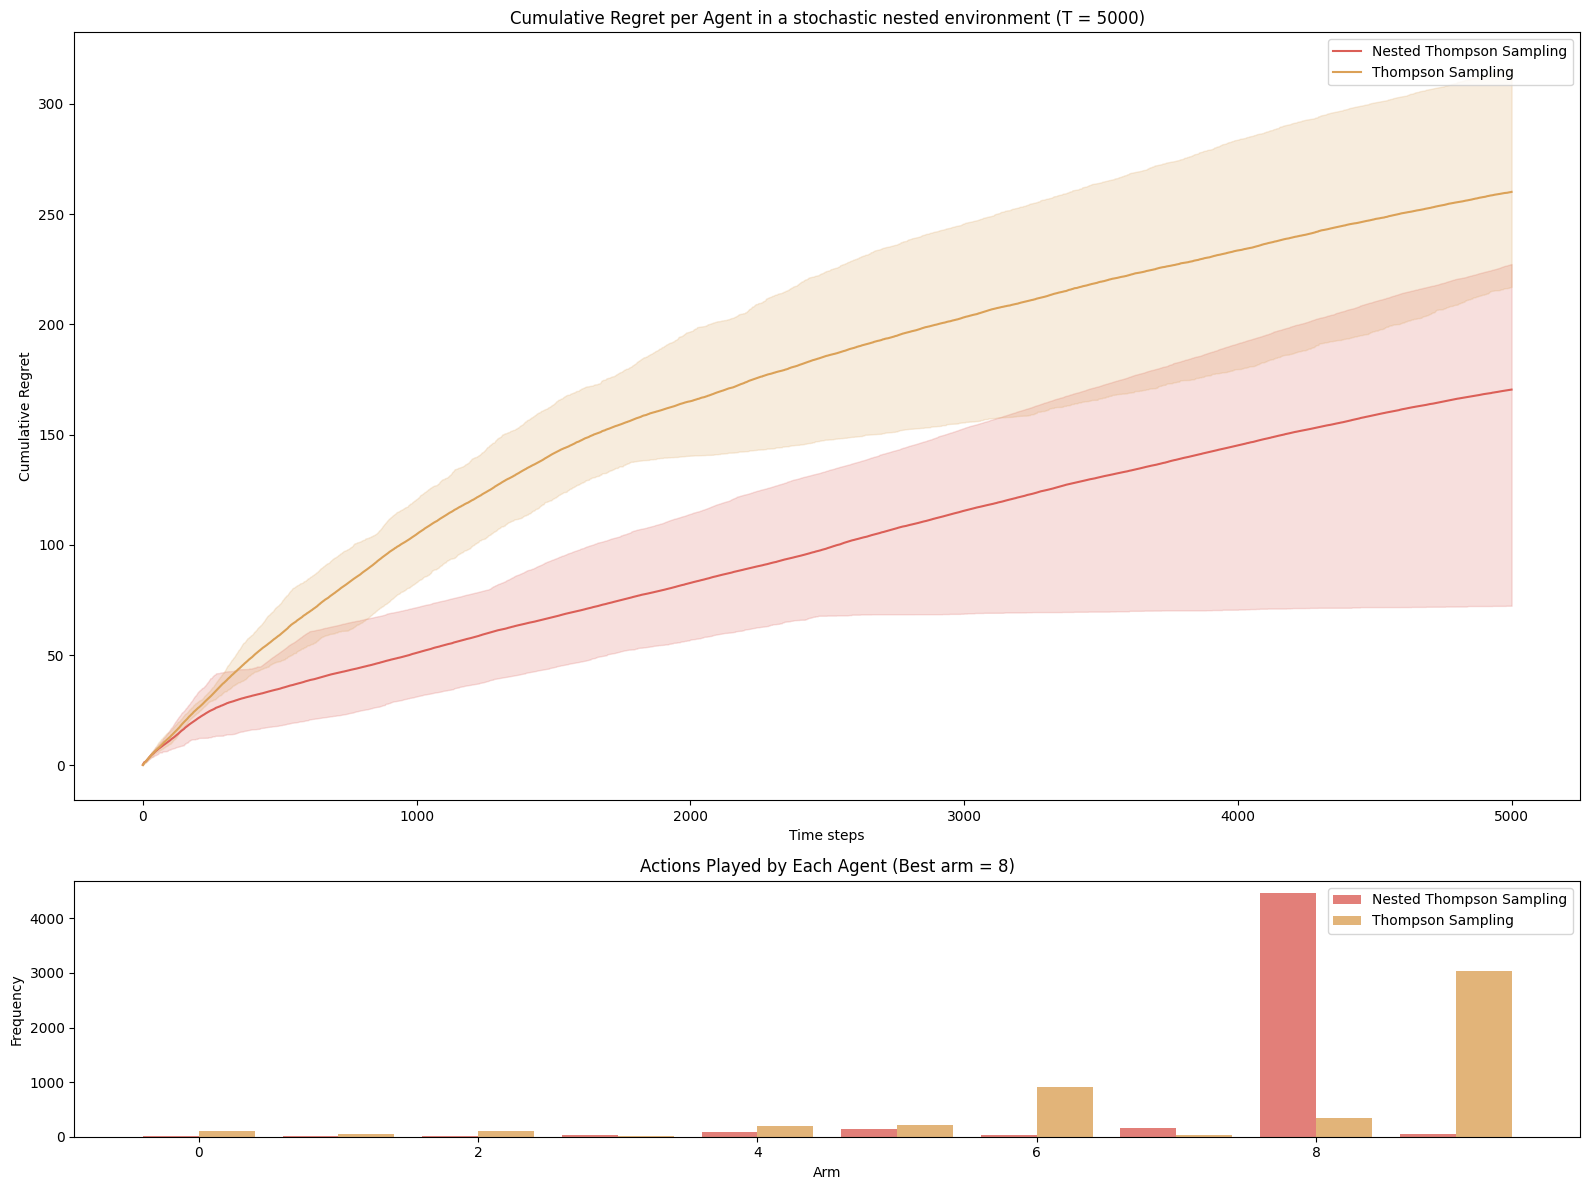

In [27]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
ts = TS(tree, T)
nts = NTS(tree, T)


regrets = experiment(environment=env, agents=[nts, ts], Nmc=10, T=T)

plot_regret_and_histogram(regrets, agents=[nts, ts], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)